This lab on Polynomial Regression and Step Functions in R comes from p. 288-292 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. It was re-implemented in Fall 2016 in `tidyverse` format by Amelia McNamara and R. Jordan Crouser at Smith College.

In [1]:
list.of.packages <- c("dplyr","ggplot2","ISLR")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

In [2]:
library(ISLR)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# 7.8.1 Polynomial Regression and Step Functions

In this lab, we'll explore how to generate the `Wage` dataset models we saw in class. We first fit the polynomial regression model using the following command:

In [3]:
fit = lm(wage ~ poly(age, 4), data = Wage)
coef(summary(fit))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),111.70361,0.7287409,153.283015,0.000000e+00
"poly(age, 4)1",447.06785,39.9147851,11.200558,1.484604e-28
"poly(age, 4)2",-478.31581,39.9147851,-11.983424,2.355831e-32
"poly(age, 4)3",125.52169,39.9147851,3.144742,1.678622e-03
"poly(age, 4)4",-77.91118,39.9147851,-1.951938,5.103865e-02


This syntax fits a linear model, using the `lm()` function, in order to predict
wage using a fourth-degree polynomial in `age`: `poly(age,4)`. The `poly()` command
allows us to avoid having to write out a long formula with powers
of `age`. The function returns a matrix whose columns are a basis of orthogonal
polynomials, which essentially means that each column is a linear
combination of the variables `age`, `age^2`, `age^3` and `age^4`.

If we prefer, we can also use `poly()` to obtain `age`, `age^2`, `age^3` and `age^4`
directly. We can do this by using the `raw = TRUE` argument to
the `poly()` function. Later we see that this does not affect the model in a
meaningful way -- though the choice of basis clearly affects the coefficient
estimates, it does not affect the fitted values obtained.

In [4]:
fit2 = lm(wage~poly(age, 4, raw = TRUE), data = Wage)
coef(summary(fit2))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-1.841542e+02,6.004038e+01,-3.067172,0.0021802539
"poly(age, 4, raw = TRUE)1",2.124552e+01,5.886748e+00,3.609042,0.0003123618
"poly(age, 4, raw = TRUE)2",-5.638593e-01,2.061083e-01,-2.735743,0.0062606446
"poly(age, 4, raw = TRUE)3",6.810688e-03,3.065931e-03,2.221409,0.0263977518
"poly(age, 4, raw = TRUE)4",-3.203830e-05,1.641359e-05,-1.951938,0.0510386498


We now create a grid of values for `age` at which we want predictions, and
then call the generic `predict()` function, specifying that we want standard
errors as well.

In [5]:
# Get min/max values of age using the range() function
agelims = Wage %>%
    select(age) %>%
    range

# Generate a sequence of age values spanning the range
age_grid = seq(from = min(agelims), to = max(agelims))

# Predict the value of the generated ages,
# returning the standard error using se = TRUE
preds = predict(fit, newdata = list(age = age_grid), se = TRUE)

# Compute error bands (2*SE)
se_bands = cbind("upper" = preds$fit+2*preds$se.fit, 
                 "lower" = preds$fit-2*preds$se.fit)

Finally, we plot the data and add the fit from the degree-4 polynomial.

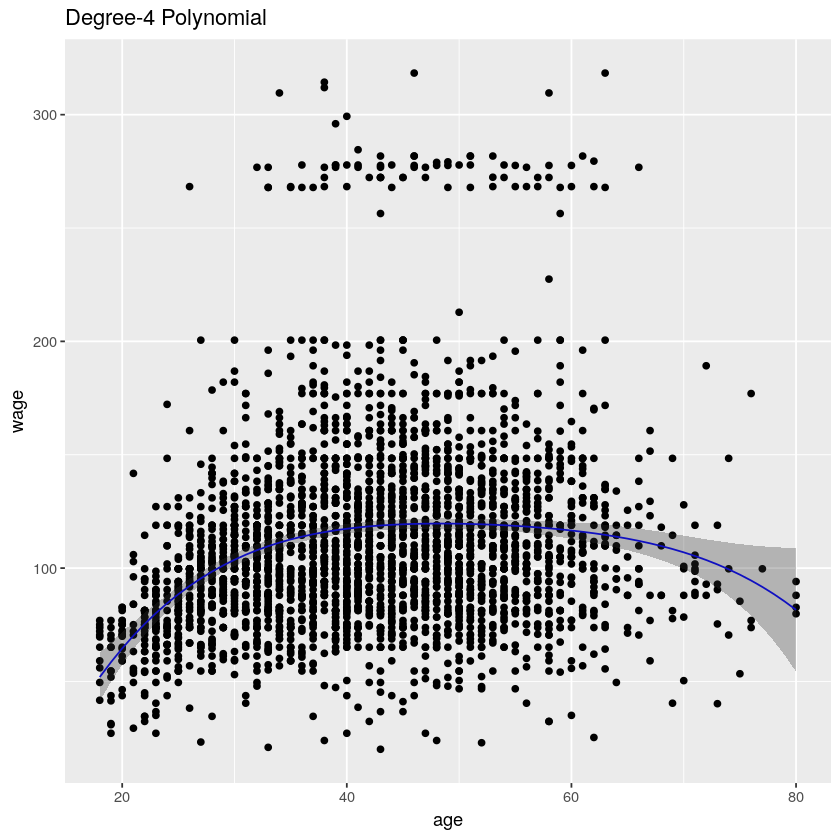

In [6]:
ggplot() +
  geom_point(data = Wage, aes(x = age, y = wage)) +
  geom_line(aes(x = age_grid, y = preds$fit), color = "#0000FF") +
  geom_ribbon(aes(x = age_grid, 
                  ymin = se_bands[,"lower"], 
                  ymax = se_bands[,"upper"]), 
              alpha = 0.3) +
  xlim(agelims) +
  labs(title = "Degree-4 Polynomial")

We mentioned earlier that whether or not an orthogonal set of basis functions
is produced in the `poly()` function will not affect the model obtained
in a meaningful way. What do we mean by this? The fitted values obtained
in either case are identical (up to a miniscule rounding error caused by building our models on a computer):

In [7]:
preds2 = predict(fit2, newdata = list(age = age_grid), se = TRUE)

# Calculate the difference between the two estimates, print out the first few values
head(abs(preds$fit - preds2$fit))

1            2            3            4            5            6 
2.813039e-11 2.227551e-11 1.725198e-11 1.311662e-11 9.606538e-12 6.792789e-12

# Deciding on a degree

In performing a polynomial regression we must decide on the degree of
the polynomial to use. One way to do this is by using hypothesis tests. We
now fit models ranging from linear to a degree-5 polynomial and seek to
determine the simplest model which is sufficient to explain the relationship
between `wage` and `age`.

We can do this using the `anova()` function, which performs an
analysis of variance (ANOVA, using an F-test) in order to test the null
hypothesis that a model $M_1$ is sufficient to explain the data against the 
alternative hypothesis that a more complex model $M_2$ is required. In order
to use the `anova()` function, $M_1$ and $M_2$ must be **nested models**: the
predictors in $M_1$ must be a subset of the predictors in $M_2$. In this case,
we fit five different models and sequentially compare the simpler model to
the more complex model:

In [8]:
fit_1 = lm(wage~age, data = Wage)
fit_2 = lm(wage~poly(age,2), data = Wage)
fit_3 = lm(wage~poly(age,3), data = Wage)
fit_4 = lm(wage~poly(age,4), data = Wage)
fit_5 = lm(wage~poly(age,5), data = Wage)
print(anova(fit_1,fit_2,fit_3,fit_4,fit_5))

Analysis of Variance Table

Model 1: wage ~ age
Model 2: wage ~ poly(age, 2)
Model 3: wage ~ poly(age, 3)
Model 4: wage ~ poly(age, 4)
Model 5: wage ~ poly(age, 5)
  Res.Df     RSS Df Sum of Sq        F    Pr(>F)    
1   2998 5022216                                    
2   2997 4793430  1    228786 143.5931 < 2.2e-16 ***
3   2996 4777674  1     15756   9.8888  0.001679 ** 
4   2995 4771604  1      6070   3.8098  0.051046 .  
5   2994 4770322  1      1283   0.8050  0.369682    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The $p$-value comparing the linear Model 1 to the quadratic Model 2 is
essentially zero $(<10^{-15})$, indicating that a linear fit is not sufficient. Similarly the $p$-value comparing the quadratic Model 2 to the cubic Model 3
is very low (0.0017), so the quadratic fit is also insufficient. The $p$-value
comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately
0.05 while the degree-5 polynomial Model 5 seems unnecessary because its $p$-value is 0.37. Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

In this case, instead of using the `anova()` function, we could also have obtained
these $p$-values more succinctly by exploiting the fact that `poly()` creates
orthogonal polynomials.

In [9]:
print(coef(summary(fit_5)))

                Estimate Std. Error     t value     Pr(>|t|)
(Intercept)    111.70361  0.7287647 153.2780243 0.000000e+00
poly(age, 5)1  447.06785 39.9160847  11.2001930 1.491111e-28
poly(age, 5)2 -478.31581 39.9160847 -11.9830341 2.367734e-32
poly(age, 5)3  125.52169 39.9160847   3.1446392 1.679213e-03
poly(age, 5)4  -77.91118 39.9160847  -1.9518743 5.104623e-02
poly(age, 5)5  -35.81289 39.9160847  -0.8972045 3.696820e-01


Notice that the p-values are the same, and in fact the square of the
t-statistics are equal to the F-statistics from the `anova()` function; for
example:

In [10]:
(-11.983)^2

[1] 143.5923

However, the ANOVA method works whether or not we used orthogonal
polynomials; it also works when we have other terms in the model as well.
For example, we can use `anova()` to compare these three models:

In [11]:
fit_1 = lm(wage~education+age, data = Wage)
fit_2 = lm(wage~education+poly(age,2), data = Wage)
fit_3 = lm(wage~education+poly(age,3), data = Wage)
print(anova(fit_1,fit_2,fit_3))

Analysis of Variance Table

Model 1: wage ~ education + age
Model 2: wage ~ education + poly(age, 2)
Model 3: wage ~ education + poly(age, 3)
  Res.Df     RSS Df Sum of Sq        F Pr(>F)    
1   2994 3867992                                 
2   2993 3725395  1    142597 114.6969 <2e-16 ***
3   2992 3719809  1      5587   4.4936 0.0341 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


As an alternative to using hypothesis tests and ANOVA, we could choose
the polynomial degree using cross-validation as we have in previous labs.

Next we consider the task of predicting whether an individual earns more
than \$250,000 per year. We proceed much as before, except that first we
create the appropriate response vector, and then apply the `glm()` function
using `family = "binomial"` in order to fit a polynomial logistic regression
model:

In [12]:
fit = glm(I(wage>250)~poly(age,4), data = Wage, family = binomial)

Note that we again use the wrapper `I()` to create this binary response
variable on the fly. The expression `wage>250` evaluates to a logical variable
containing `TRUEs` and `FALSEs`, which `glm()` coerces to binary by setting the
`TRUEs` to 1 and the `FALSEs` to 0.

Once again, we make predictions using the `predict()` function:

In [13]:
preds = predict(fit, newdata = list(age = age_grid), se = TRUE)

However, calculating the confidence intervals is slightly more involved than
in the linear regression case. The default prediction type for a glm() model
is type="link", which is what we use here. This means we get predictions
for the logit: that is, we have fit a model of the form

$$log\left(\frac{Pr(Y = 1|X)}{1 − Pr(Y = 1|X)}\right)= X\beta$$

and the predictions given are of the form $X\hat \beta$. The standard errors given are
also of this form. In order to obtain confidence intervals for $Pr(Y = 1|X)$,
we use the transformation:

$$Pr(Y = 1|X) = \frac{e^{X\beta}}{1 + e^{X\beta}}$$

In [14]:
pfit = exp(preds$fit) / (1+exp(preds$fit))

se_bands_logit = cbind("upper" = preds$fit+2*preds$se.fit, 
                       "lower" = preds$fit-2*preds$se.fit)

se_bands = exp(se_bands_logit) / (1+exp(se_bands_logit))

We could have directly computed the probabilities by selecting
the `type = "response"` option in the `predict()` function. However, the corresponding confidence intervals would not have been sensible because we would end up with negative probabilities!

Now we're ready to draw the second plot we saw in class:

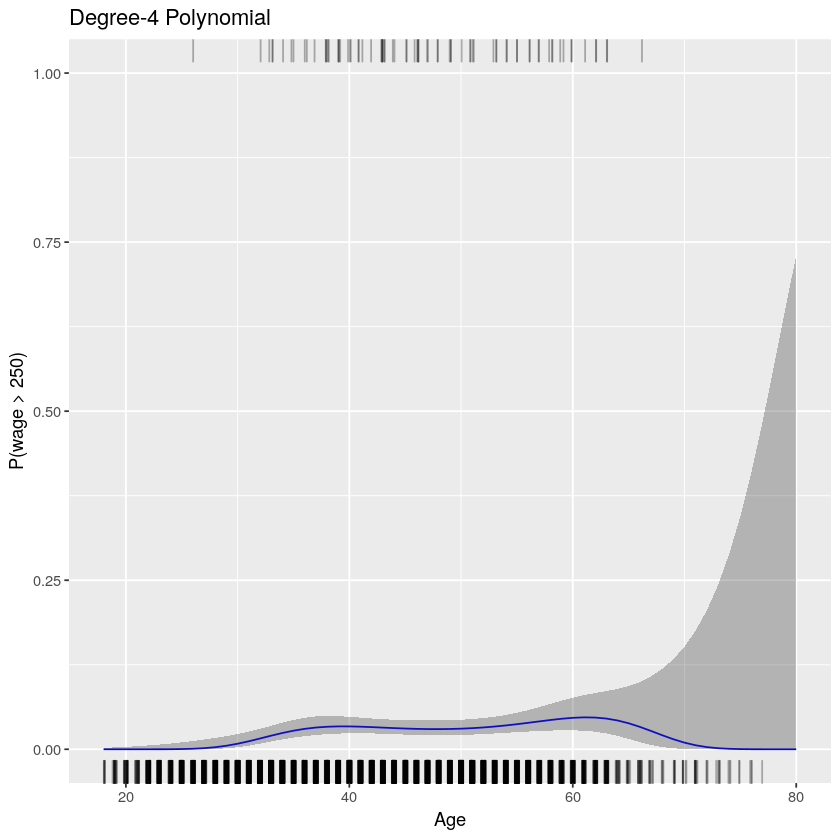

In [15]:
high = Wage %>%
  filter(wage > 250)

low = Wage %>%
  filter(wage <= 250)

ggplot() +
  geom_rug(data = low, aes(x = jitter(age), y = wage), sides = "b", alpha = 0.3) +
  geom_rug(data = high, aes(x = jitter(age), y = wage), sides = "t", alpha = 0.3) +
  geom_line(aes(x = age_grid, y = pfit), color = "#0000FF") +
  geom_ribbon(aes(x = age_grid, 
                  ymin = se_bands[,"lower"], 
                  ymax = se_bands[,"upper"]), 
              alpha = 0.3) +
  xlim(agelims) +
  ylim(c(0,1)) +
  labs(title = "Degree-4 Polynomial",
       x = "Age",
       y = "P(wage > 250)")

We have drawn the `age` values corresponding to the observations with `wage`
values above 250 as gray marks on the top of the plot, and those with `wage`
values below 250 are shown as gray marks on the bottom of the plot. We
used the `jitter()` function to jitter the `age` values a bit so that observations
with the same `age` value do not cover each other up. This is often called a
*rug plot*.

# Step functions
In order to fit a step function, we use the `cut()` function:

In [16]:
table(cut(Wage$age,4))
fit_step = lm(wage~cut(age,4), data = Wage)
print(coef(summary(fit)))


(17.9,33.5]   (33.5,49]   (49,64.5] (64.5,80.1] 
        750        1399         779          72 

                Estimate Std. Error    z value     Pr(>|z|)
(Intercept)    -4.301228  0.3450738 -12.464663 1.163621e-35
poly(age, 4)1  71.964174 26.1175633   2.755394 5.862151e-03
poly(age, 4)2 -85.772899 35.9043225  -2.388930 1.689754e-02
poly(age, 4)3  34.162564 19.6889645   1.735112 8.272092e-02
poly(age, 4)4 -47.400800 24.0909406  -1.967578 4.911664e-02


Here `cut()` automatically picked the cutpoints at 33.5, 49, and 64.5 years
of age. We could also have specified our own cutpoints directly using the
`breaks` option. The function `cut()` returns an ordered categorical variable;
the lm() function then creates a set of dummy variables for use in the regression.
The `age<33.5` category is left out, so the intercept coefficient of
\$94,160 can be interpreted as the average salary for those under 33.5 years
of age, and the other coefficients can be interpreted as the average additional
salary for those in the other age groups. 

We can produce predictions
and plots just as we did in the case of the polynomial fit_

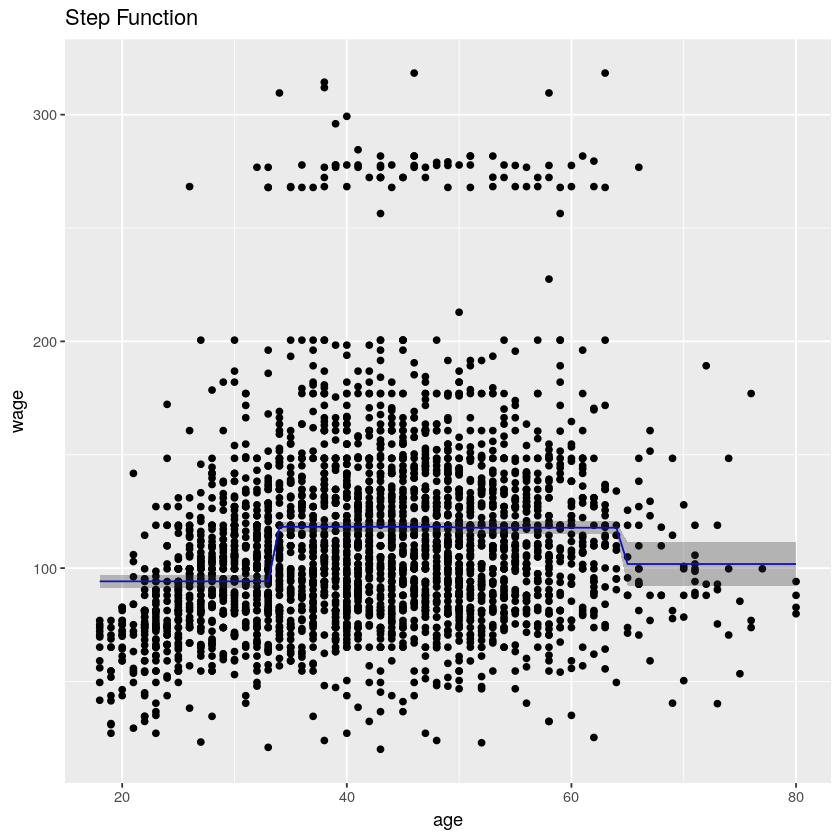

In [17]:
# Predict the value of the generated ages, returning the standard error using se = TRUE
preds = predict(fit_step, newdata = list(age = age_grid), se = TRUE)

# Compute error bands (2*SE)
se_bands = cbind("upper" = preds$fit+2*preds$se.fit, 
                 "lower" = preds$fit-2*preds$se.fit)

# Plot
ggplot() +
  geom_point(data = Wage, aes(x = age, y = wage)) +
  geom_line(aes(x = age_grid, y = preds$fit), color = "#0000FF") +
  geom_ribbon(aes(x = age_grid, 
                  ymin = se_bands[,"lower"], 
                  ymax = se_bands[,"upper"]), 
              alpha = 0.3) +
  xlim(agelims) +
  labs(title = "Step Function")

# Getting credit

To get credit for this lab, post your responses to the following questions:
 - What is one real-world example where you might try polynomial regression? Why?
 - What is one real-world example where you might try using a step function? Why?
 
to [Moodle](https://moodle.smith.edu/mod/quiz/view.php?id=262426).